In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, mutual_info_score, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import cv


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# type of each column
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [5]:
for col in df.select_dtypes(include=['object']):
    print(col, ":" ,df[col].unique())

person_home_ownership : ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent : ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade : ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file : ['Y' 'N']


In [6]:
# check loan grade is ordinal or not?
df.groupby('loan_grade').head(3).reset_index(drop=True).sort_values(by='loan_grade')

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
10,21,10000,OWN,2.0,HOMEIMPROVEMENT,A,4500,8.63,1,0.45,N,2
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
8,24,83000,RENT,8.0,PERSONAL,A,35000,8.90,1,0.42,N,2
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
6,26,77100,RENT,8.0,EDUCATION,B,35000,12.42,1,0.45,N,3
7,24,78956,RENT,5.0,MEDICAL,B,35000,11.11,1,0.44,N,4
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
13,23,113000,RENT,8.0,DEBTCONSOLIDATION,D,35000,18.25,1,0.31,N,4


In [7]:
# check for other missing value percentage
(df.isnull().sum() / len(df)).sort_values(ascending=False) * 100

loan_int_rate                 9.563856
person_emp_length             2.747000
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

Value counts of 0    25473
1     7108
Name: loan_status, dtype: int64


Text(0.5, 1.0, 'Loan status of Customers')

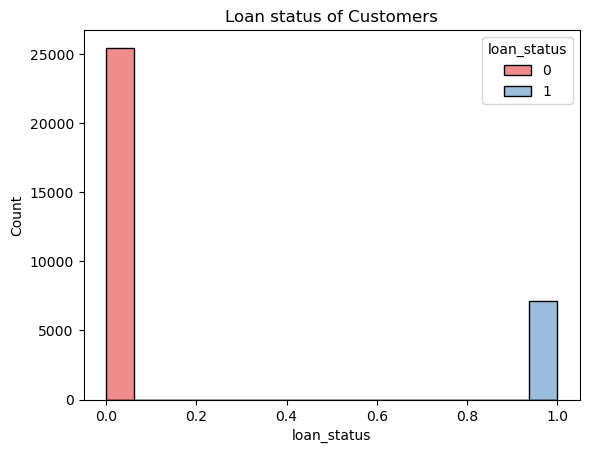

In [8]:
# check the class balance
print("Value counts of", df['loan_status'].value_counts())
sns.histplot(data=df, x="loan_status", hue="loan_status", palette = "Set1")
plt.title('Loan status of Customers')

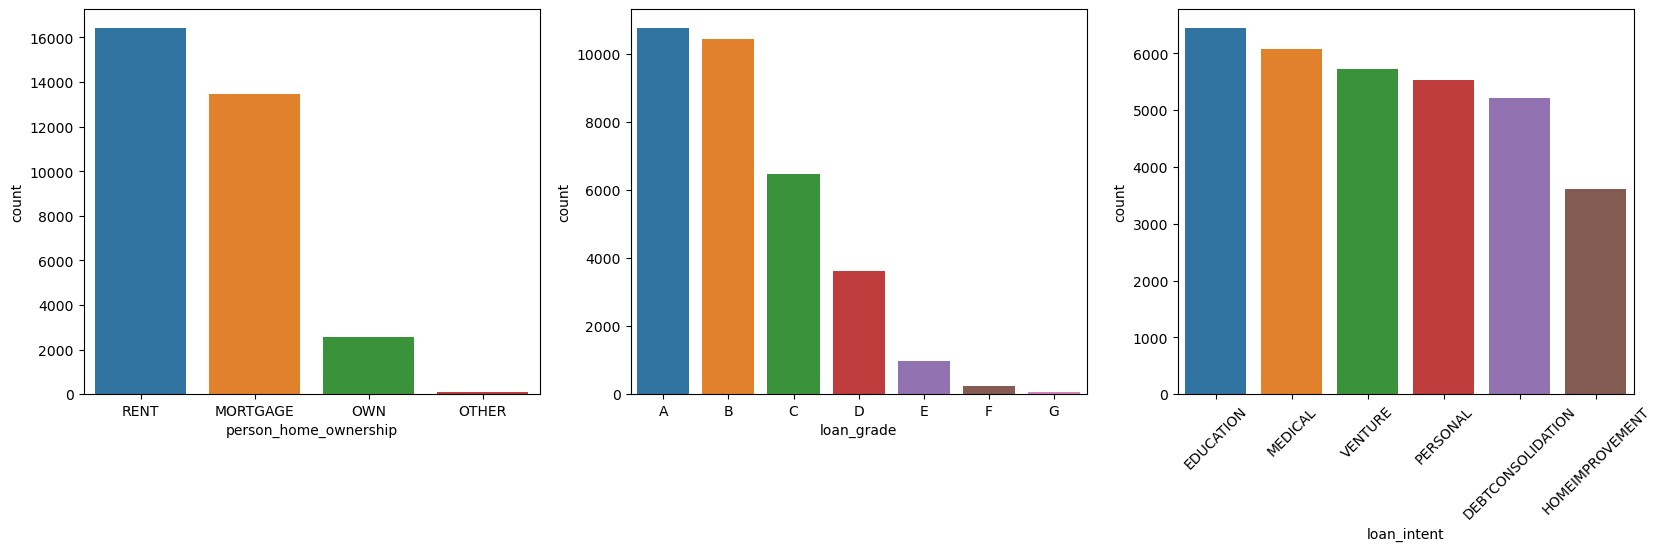

In [9]:
columns = {0:'person_home_ownership', 1: 'loan_grade', 2: 'loan_intent'}
fig, ax = plt.subplots(1,3, figsize=(20, 5))

for key, val in columns.items(): 
    sns.countplot(x=val,  data=df, ax=ax[key], order = df[val].value_counts().index)
    plt.xticks(rotation=45)

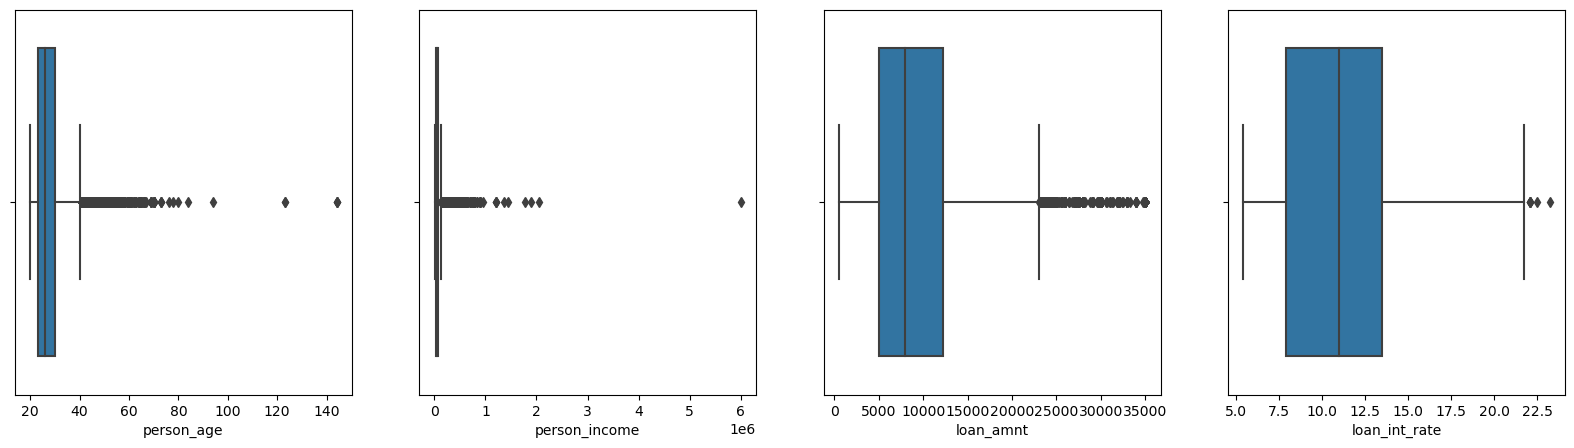

In [10]:
columns = {0:'person_age' , 1: 'person_income', 2: 'loan_amnt', 3:'loan_int_rate'}
fig, ax = plt.subplots(1,len(columns), figsize=(20, 5))
for key, val in columns.items(): 
    sns.boxplot(x=df[val], ax= ax[key])

Text(0.5, 1.0, "Person's Age Distribution")

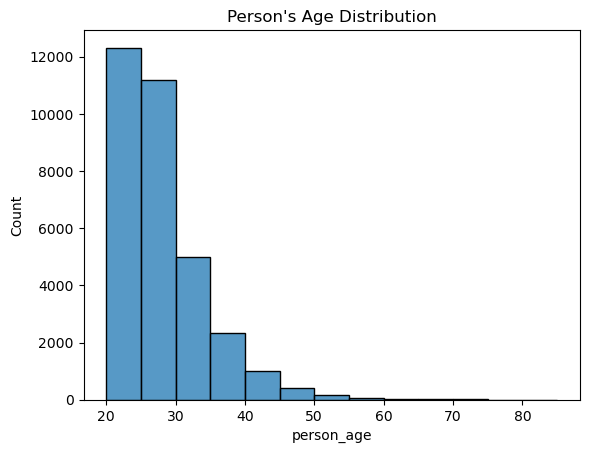

In [11]:
# assuming a persons limit is less than 90 years old for loan eligibility 
df2 = df.loc[(df['person_age'] <= 90) &  (df['person_income'] < 6e6) ]

# age distribution
sns.histplot(data=df2, x ='person_age', binwidth=5)
plt.title("Person's Age Distribution")

<Axes: xlabel='person_age', ylabel='loan_amnt'>

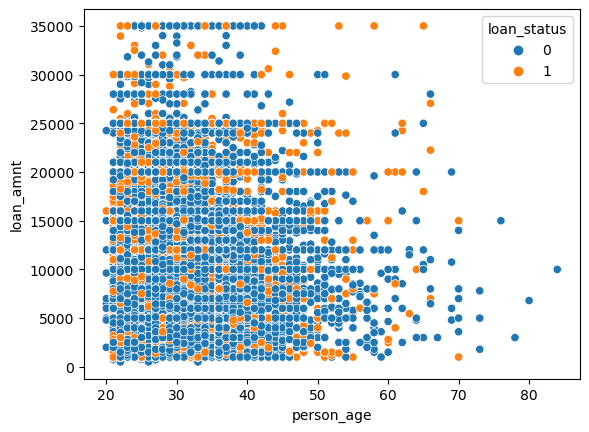

In [12]:
# age vs income 
sns.scatterplot(data=df2, x="person_age", y="loan_amnt", hue='loan_status')

<Axes: xlabel='person_age', ylabel='loan_amnt'>

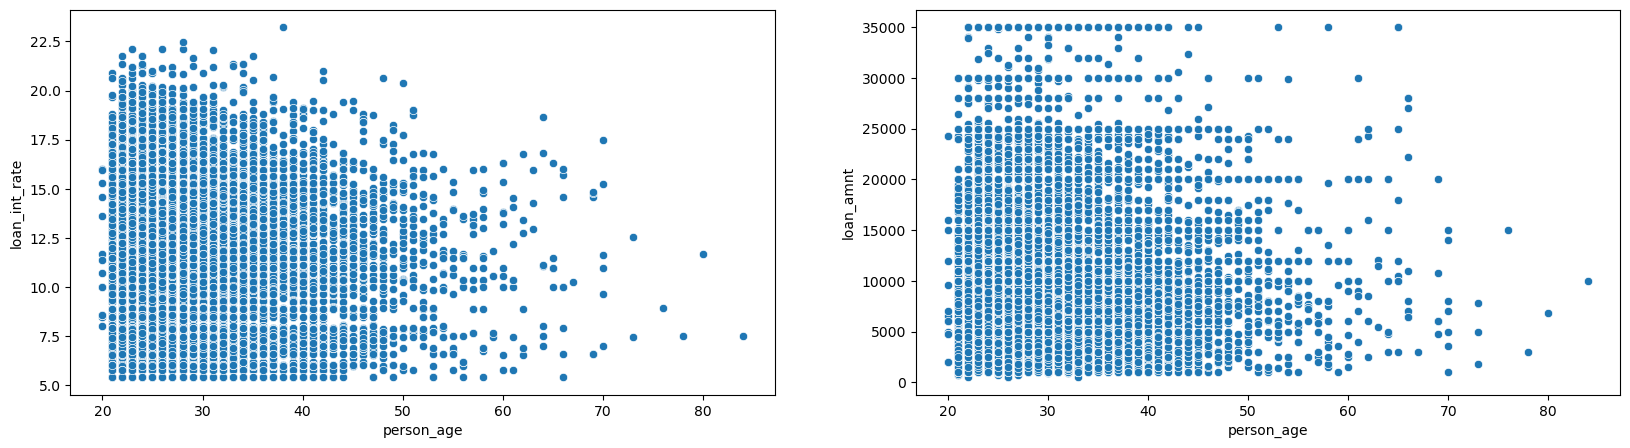

In [13]:
# age vs loan amount and loan rate
fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.scatterplot(data=df2, x="person_age", y="loan_int_rate", ax=ax[0])
sns.scatterplot(data=df2, x="person_age", y="loan_amnt", ax=ax[1])

In [18]:
# Convert Yes and No values to 0 and 1
data_df=df2.copy()
data_df['cb_person_default_on_file']=data_df.cb_person_default_on_file.map(dict(Y=1, N=0))

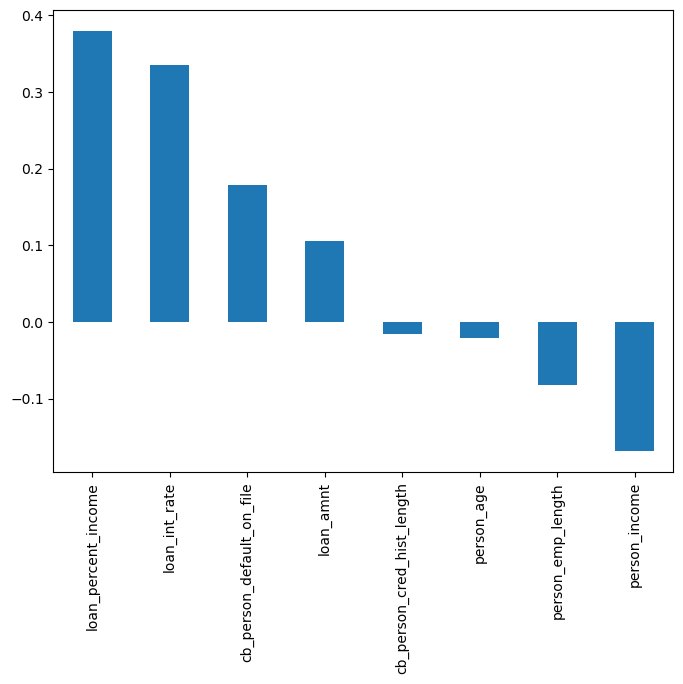

In [19]:
# check correlation between the target and the features
conti_df= data_df.select_dtypes(exclude=[object])

corr_with_tot_count = conti_df.corr()["loan_status"].sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_tot_count.drop("loan_status").plot.bar()
plt.show()

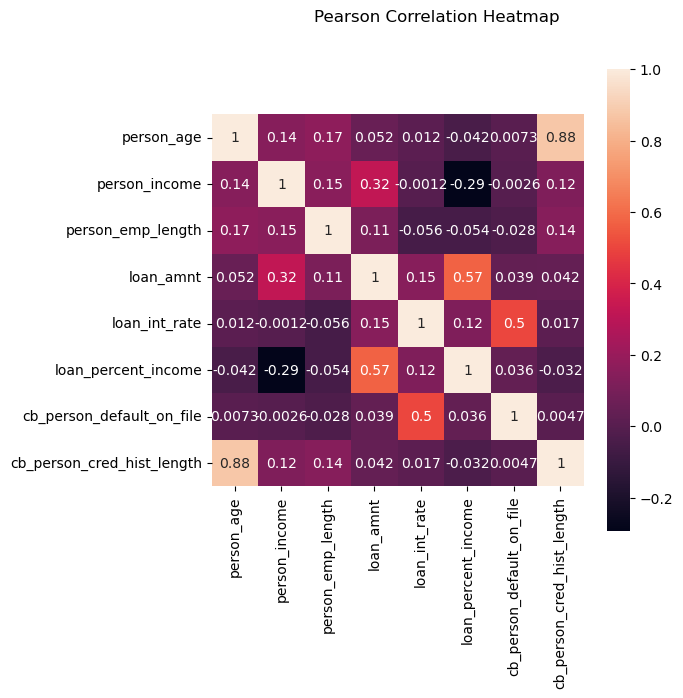

In [20]:
# check for correlation among the features
plt.figure(figsize=(6,6))

sns.heatmap(conti_df.drop(['loan_status'],axis=1).corr(), square=True, annot=True,)
plt.suptitle("Pearson Correlation Heatmap")
plt.show()

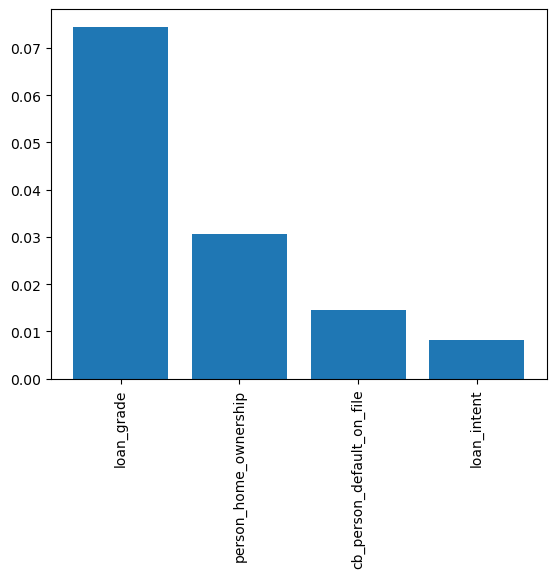

In [21]:
# returns the MI scores
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df.loan_status)

# select categorial variables excluding loan status
cat_vars = df.select_dtypes(include=object)

# compute the MI score between each categorical variable and the target
feature_importance_df = cat_vars.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
plt.bar(feature_importance_df.index, height = feature_importance_df.values)
plt.xticks(rotation=90)
plt.show()


In [22]:
feature_importance_df

loan_grade                   0.074487
person_home_ownership        0.030677
cb_person_default_on_file    0.014507
loan_intent                  0.008076
dtype: float64

In [24]:
# select the final set of features
selected_features = df.drop(['loan_intent', 'person_home_ownership'], axis=1) 

# Label encoding for loan grade
le = preprocessing.LabelEncoder()
selected_features['loan_grade'] = le.fit_transform(selected_features.loan_grade.values)

selected_features.head(3)

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,123.0,3,35000,16.02,1,0.59,Y,3
1,21,9600,5.0,1,1000,11.14,0,0.10,N,2
2,25,9600,1.0,2,5500,12.87,1,0.57,N,3


In [25]:
# returns the model performance in terms of accuracy, classification report and the confusion matrix
def model_performance(y_test,y_pred, method):
    
    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")
    
    #generate the classification report
    print(classification_report(y_test,y_pred))
    
    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="Reds" , fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)
    
# select the features and the target variables
X = selected_features.drop(['loan_status'],axis=1)
y = selected_features['loan_status']

# Train/ Test Split using stratify sampling to solve the class imbalance problem
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=33)